In [1]:
!unzip '/content/music-midi.zip'

Archive:  /content/music-midi.zip
   creating: music-midi/
   creating: music-midi/Mozart/
  inflating: __MACOSX/music-midi/._Mozart  
   creating: music-midi/Chopin/
  inflating: __MACOSX/music-midi/._Chopin  
  inflating: music-midi/.DS_Store    
  inflating: __MACOSX/music-midi/._.DS_Store  
   creating: music-midi/Beethoven/
  inflating: __MACOSX/music-midi/._Beethoven  
   creating: music-midi/Bach/
  inflating: __MACOSX/music-midi/._Bach  
  inflating: music-midi/Mozart/K495 Horn Concerto n4 1mov.mid  
  inflating: __MACOSX/music-midi/Mozart/._K495 Horn Concerto n4 1mov.mid  
  inflating: music-midi/Mozart/K626 Requiem 05 Recordare.mid  
  inflating: __MACOSX/music-midi/Mozart/._K626 Requiem 05 Recordare.mid  
  inflating: music-midi/Mozart/K492 Overture ''Le Nozze di Figaro''.mid  
  inflating: __MACOSX/music-midi/Mozart/._K492 Overture ''Le Nozze di Figaro''.mid  
  inflating: music-midi/Mozart/K427 Great Mass 1mov.mid  
  inflating: __MACOSX/music-midi/Mozart/._K427 Great Mass

## Data Pre-processing

In [2]:
!pip install pretty_midi music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=2874108b7746a8b5dece3c4f8f02a7db5b823a0c4640d7b4b84b3e7747e1051c
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [3]:
import os
import numpy as np
from music21 import converter, instrument, note, chord
import concurrent.futures
import warnings

# Hiding warnings about missing instrument info in MIDI files
warnings.filterwarnings('ignore', category=UserWarning, module='music21')

# Function to extract notes and chords from a MIDI file
def extract_notes_and_chords(file_path):
    notes = []
    midi = converter.parse(file_path)
    parts = instrument.partitionByInstrument(midi)
    if parts:  # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else:  # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

# Function to process a composer's files
def process_composer(composer, dataset_path):
    composer_notes = []
    folder_path = os.path.join(dataset_path, composer)
    for file in os.listdir(folder_path):
        if file.endswith('.mid'):
            file_path = os.path.join(folder_path, file)
            notes = extract_notes_and_chords(file_path)
            composer_notes.extend(notes)
    return composer, composer_notes

# Path to your dataset
dataset_path = '/content/music-midi'

# List of composers
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold the notes and chords for each composer
composer_notes = {}

# Using concurrent.futures to process files in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    results = [executor.submit(process_composer, composer, dataset_path) for composer in composers]
    for f in concurrent.futures.as_completed(results):
        composer, notes = f.result()
        composer_notes[composer] = notes

# Save extracted notes and chords for further use
np.save('composer_notes.npy', composer_notes)

# Print a sample of the notes and chords extracted
for composer, notes in composer_notes.items():
    print(f"{composer}: {notes[:10]}...")


Bach: ['D5', 'D5', '2.5.9', '7.9', '5.7', 'A3', 'D3', 'D3', 'F5', 'E5']...
Mozart: ['0.4.7', 'C5', 'E5', 'G5', 'C4', '0.4', '4.7', 'G4', '2.5.7', 'B4']...
Chopin: ['F2', 'C3', '5.8', '10.0', '7.10', '0.5', 'C3', '8.0', 'C3', '10.1']...
Beethoven: ['B4', 'G2', 'G3', 'D3', 'C5', '2.4', 'A3', '2.4', 'D3', '11.2']...


## Encode Notes and Chords

In [4]:
# Flatten all notes and chords
all_notes = []
for notes in composer_notes.values():
    all_notes.extend(notes)

# Create a sorted list of unique notes and chords
unique_notes = sorted(set(all_notes))

# Create a dictionary to map notes and chords to integers
note_to_int = {note: number for number, note in enumerate(unique_notes)}

# Convert notes and chords to integers
composer_sequences = {composer: [note_to_int[note] for note in notes] for composer, notes in composer_notes.items()}

# Save mappings and sequences
np.save('note_to_int.npy', note_to_int)
np.save('composer_sequences.npy', composer_sequences)

# Print sample encoded sequences
for composer, sequence in composer_sequences.items():
    print(f"{composer}: {sequence[:10]}...")


Bach: [875, 875, 335, 673, 517, 841, 873, 873, 902, 889]...
Mozart: [63, 868, 889, 915, 867, 59, 464, 914, 324, 854]...
Chopin: [899, 866, 540, 143, 625, 66, 866, 697, 866, 161]...
Beethoven: [854, 912, 913, 873, 868, 297, 841, 297, 873, 246]...


## Create Input Sequences and Labels

In [5]:
# Define the sequence length
sequence_length = 100

# Create input sequences and labels
input_sequences = []
labels = []
label_map = {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}

for composer, sequence in composer_sequences.items():
    for i in range(len(sequence) - sequence_length):
        # Extract the sequence of notes and chords
        input_seq = sequence[i:i + sequence_length]
        # The label is the next note/chord
        label = sequence[i + sequence_length]

        input_sequences.append(input_seq)
        labels.append(label_map[composer])

# Convert to numpy arrays
input_sequences = np.array(input_sequences)
labels = np.array(labels)

# Print the shape of the data
print(f"Input sequences shape: {input_sequences.shape}")
print(f"Labels shape: {labels.shape}")


Input sequences shape: (464657, 100)
Labels shape: (464657,)


## Model Building | LSTM Model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding

# Explicit input shape declaration
input_shape = (sequence_length, )
embedding_input = Input(shape=input_shape)

# Define the embedding layer without using input_length
embedding_layer = Embedding(input_dim=len(unique_notes), output_dim=128)(embedding_input)

# Define LSTM layers
lstm_out1 = LSTM(128, return_sequences=True)(embedding_layer)
dropout_out1 = Dropout(0.3)(lstm_out1)
lstm_out2 = LSTM(128)(dropout_out1)
dropout_out2 = Dropout(0.3)(lstm_out2)

# Define output layer
output = Dense(4, activation='softmax')(dropout_out2)

# Build and compile the model
lstm_model = Model(inputs=embedding_input, outputs=output)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
lstm_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 128)            │         117,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 381,060 (1.45 MB)

 Trainable params: 381,060 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(input_sequences, labels, test_size=0.2, random_state=42)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Training the model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the model for future use
lstm_model.save('composer_lstm_model.h5')

Epoch 1/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 77s 12ms/step - accuracy: 0.7221 - loss: 0.7347 - val_accuracy: 0.9534 - val_loss: 0.1423
Epoch 2/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - accuracy: 0.9694 - loss: 0.0960 - val_accuracy: 0.9929 - val_loss: 0.0234
Epoch 3/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9937 - val_loss: 0.0191
Epoch 4/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoch 5/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 6/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9993 - val_loss: 0.0023
Epoch 7/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9989 - val_loss: 0.0035
Epoch 8/20
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.9985 -

##Model performance

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9994 - loss: 0.0029
Test Accuracy: 99.94%


##Plot the model performance

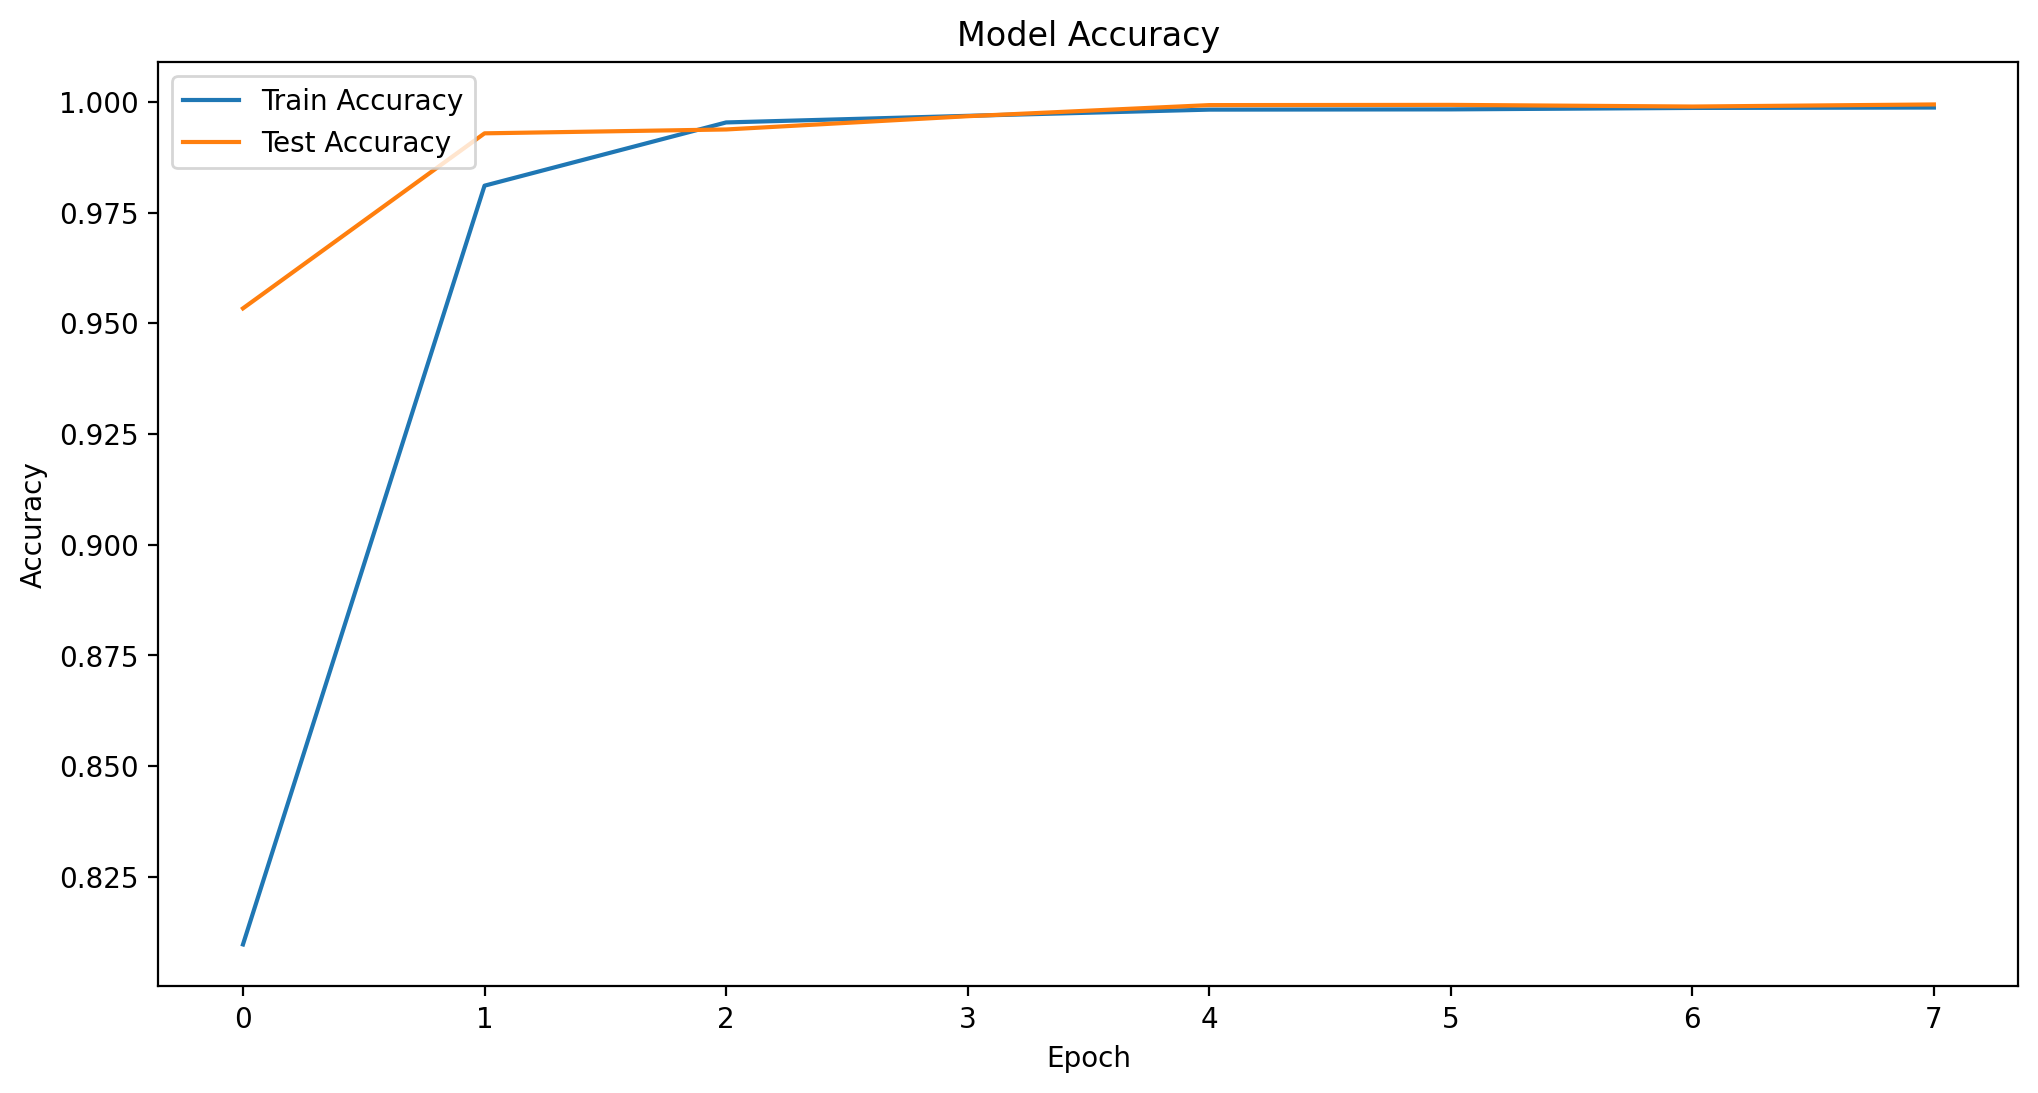

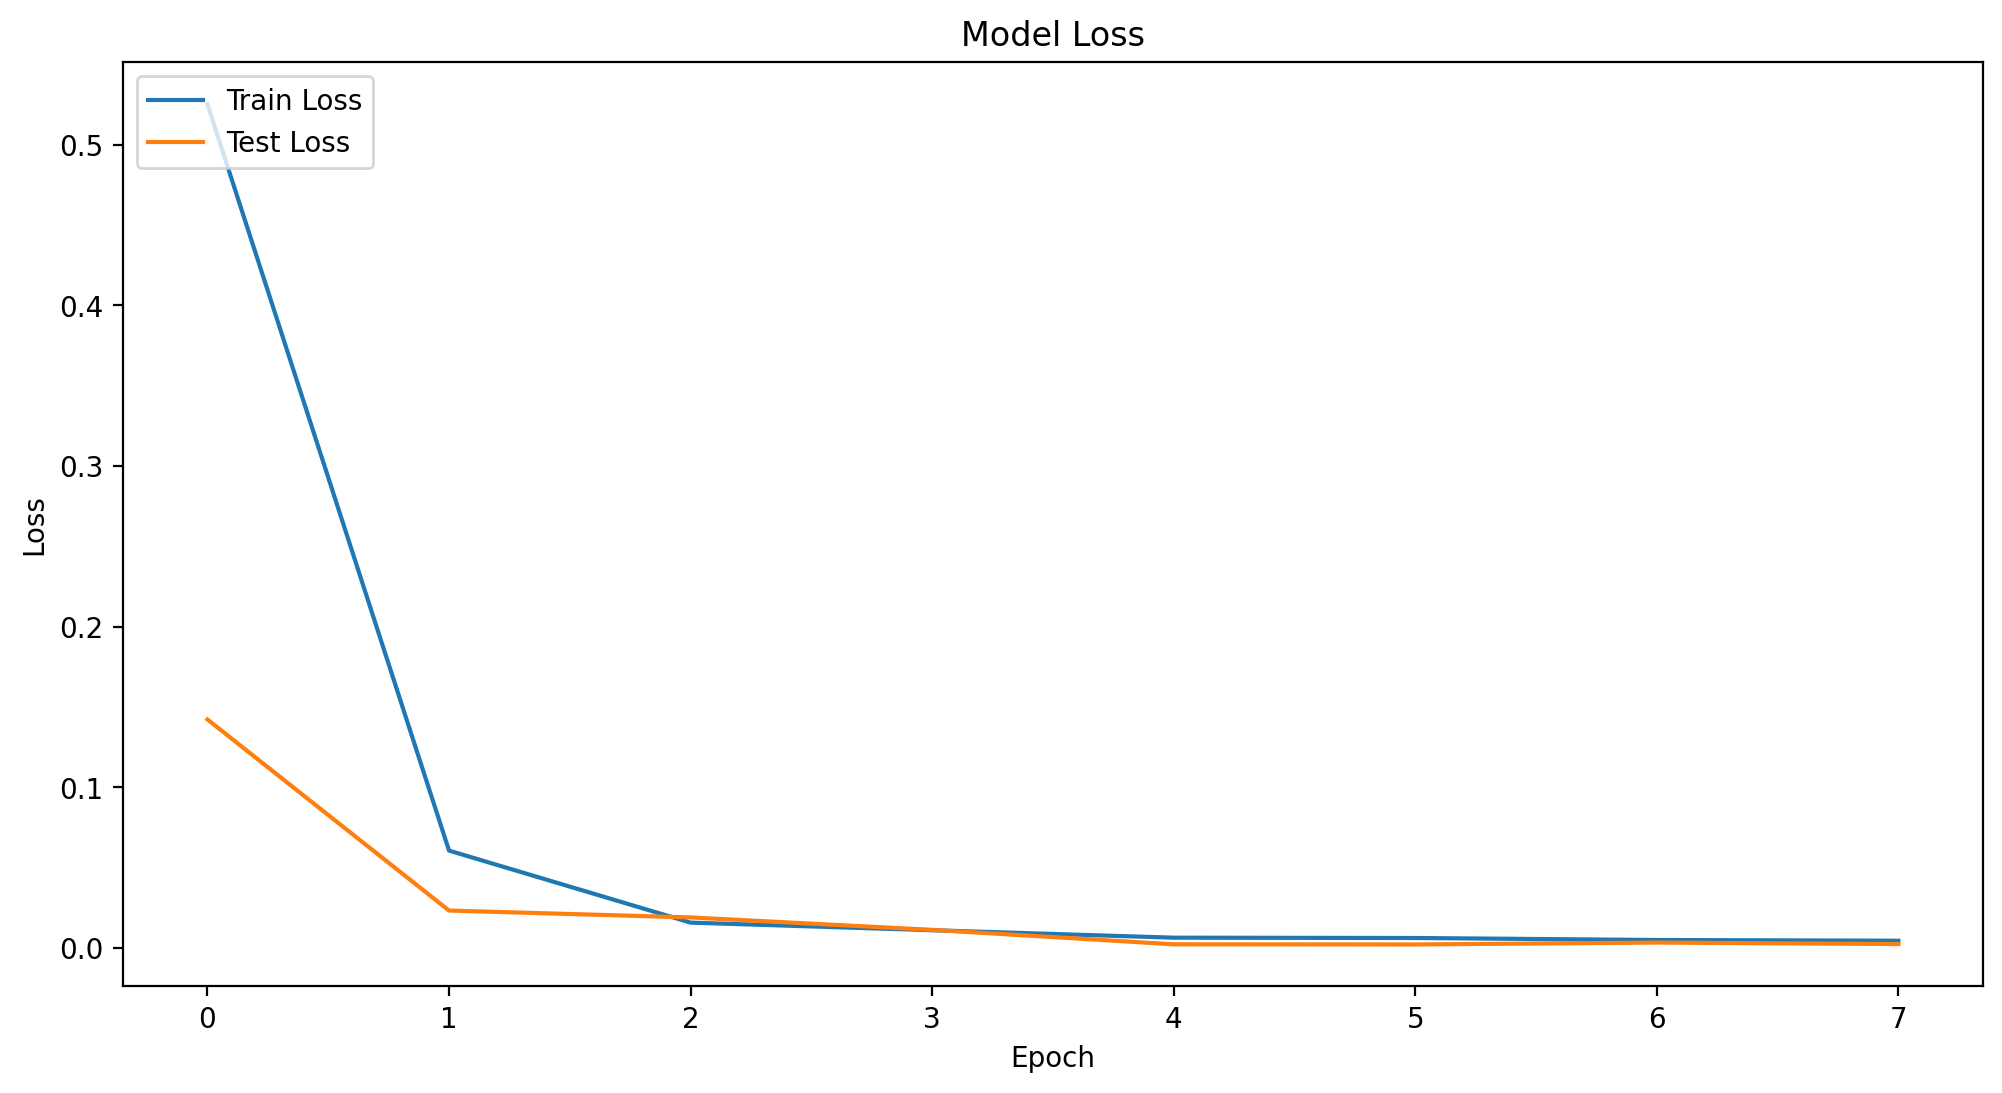

In [9]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

## Use CNN for model and evaluate performance

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming input_sequences and labels are already prepared

# Ensure input_sequences is 2D, e.g., (num_samples, sequence_length)
print(f"Original shape of input_sequences: {input_sequences.shape}")

# Check the original shape and correct it if necessary
input_sequences = np.squeeze(input_sequences)  # Remove single-dimensional entries
print(f"Shape after squeeze: {input_sequences.shape}")

# Reshape input data to include a channel dimension for Conv1D
input_sequences = np.expand_dims(input_sequences, axis=-1)  # Now shape should be (num_samples, sequence_length, 1)
print(f"Shape after expanding dims: {input_sequences.shape}")

# Assuming 'original_labels' is your original label array before any encoding
num_classes = len(np.unique(labels))  # Determine the number of classes

# One-hot encode the labels (make sure this is done ONLY ONCE)
categorical_labels = to_categorical(labels, num_classes=num_classes)
print(f"Shape of labels after one-hot encoding: {categorical_labels.shape}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(input_sequences, categorical_labels, test_size=0.2, random_state=42)

Original shape of input_sequences: (464657, 100)
Shape after squeeze: (464657, 100)
Shape after expanding dims: (464657, 100, 1)
Shape of labels after one-hot encoding: (464657, 4)


In [11]:
# Build the CNN model
cnn_model = Sequential()

# Add convolutional layers with BatchNormalization
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

# Flatten the output from the convolutional layers before feeding into dense layers
cnn_model.add(Flatten())

# Add dense layers
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

# Output layer for multi-class classification
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the model for future use
cnn_model.save('composer_cnn_multi_class_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.3980 - loss: 1.3701 - val_accuracy: 0.4292 - val_loss: 1.2068
Epoch 2/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.4595 - loss: 1.1889 - val_accuracy: 0.4783 - val_loss: 1.1527
Epoch 3/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.4855 - loss: 1.1558 - val_accuracy: 0.4797 - val_loss: 1.1299
Epoch 4/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5038 - loss: 1.1256 - val_accuracy: 0.4919 - val_loss: 1.1218
Epoch 5/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5196 - loss: 1.0993 - val_accuracy: 0.5068 - val_loss: 1.1090
Epoch 6/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5398 - loss: 1.0630 - val_accuracy: 0.5596 - val_loss: 1.0168
Epoch 7/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5589 - loss: 1.0271 - val_accuracy: 0.5932 - val_loss: 0.9513
Epoch 8/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 

# Evaluate CNN model performance

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict classes for the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and classification report
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)]))

Test Accuracy: 82.79%
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Precision: 84.24%
Recall: 82.79%

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.73      0.93      0.82     31905
     Class 1       0.90      0.79      0.84     27491
     Class 2       0.90      0.86      0.88     13492
     Class 3       0.90      0.70      0.79     20044

    accuracy                           0.83     92932
   macro avg       0.86      0.82      0.83     92932
weighted avg       0.84      0.83      0.83     92932



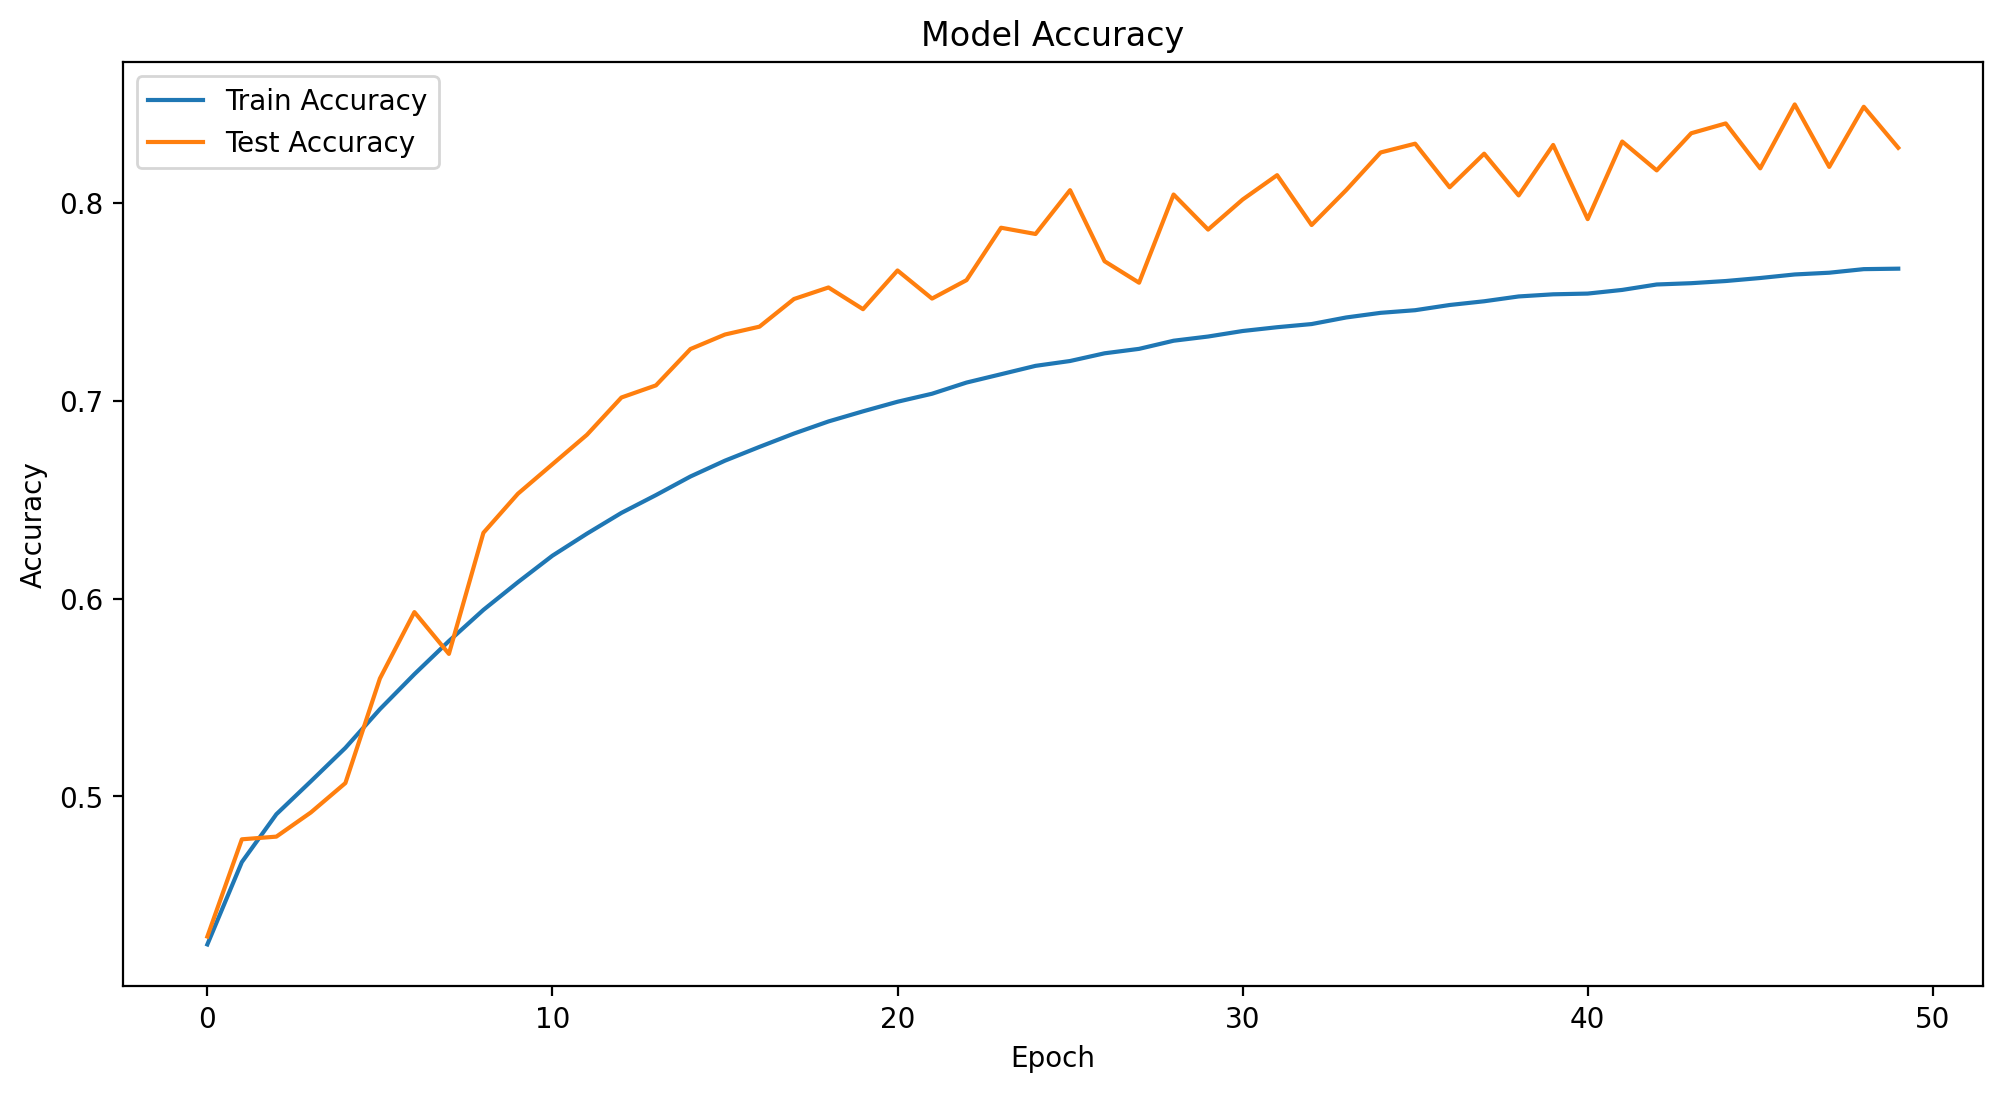

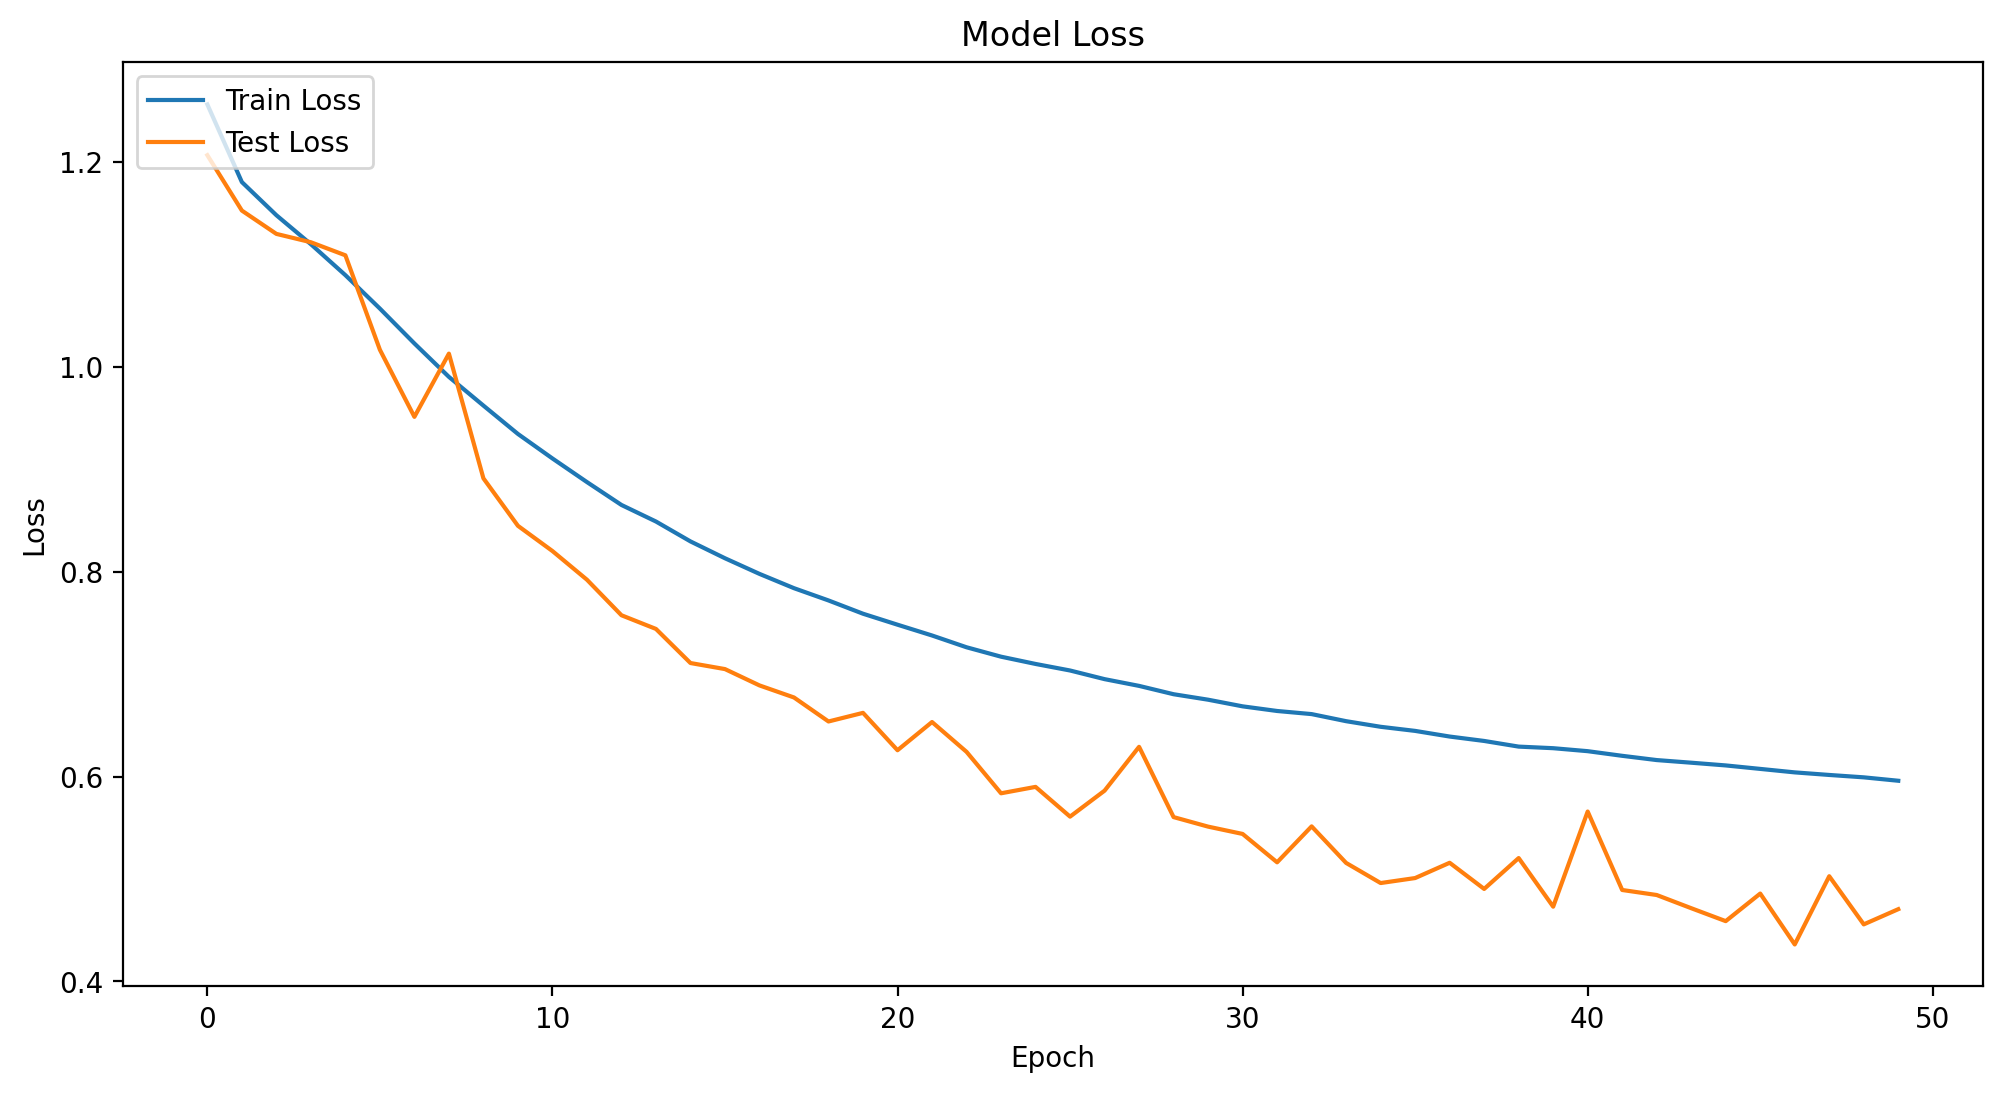

In [13]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

###Plot confusion matrix

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


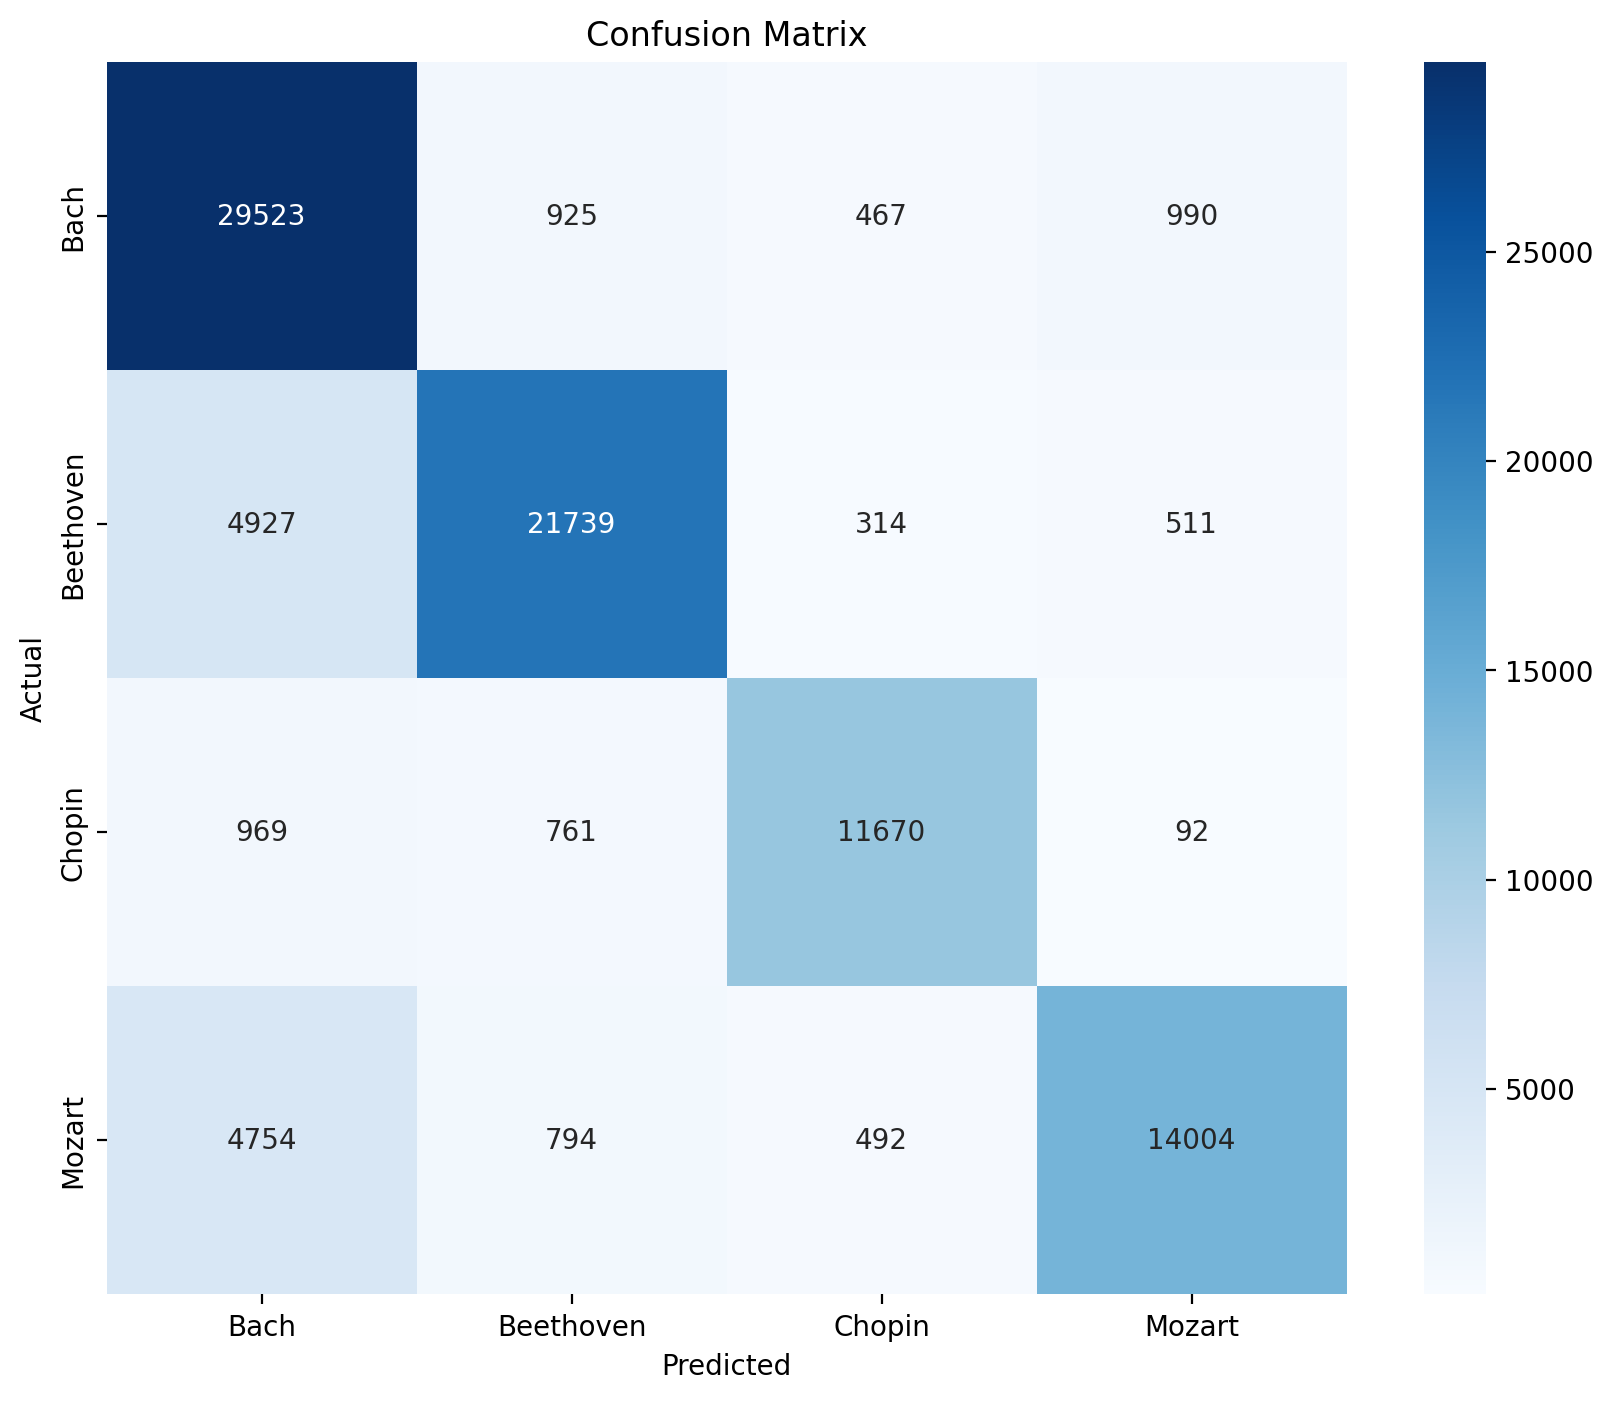

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes for the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Model Optimization
* Optimize the deep learning model by fine-tuning hyperparameters.

In [14]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Assuming input_sequences and labels are already prepared

# Number of classes (adjust based on your data)
num_classes = len(np.unique(labels))

# One-hot encode the labels
catg_labels = to_categorical(labels, num_classes=num_classes)

# Split the data into training and testing sets (80% train, 20% test)
input_sequences = np.squeeze(input_sequences)
input_sequences = np.expand_dims(input_sequences, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(input_sequences, catg_labels, test_size=0.2, random_state=42)

# Define the hypermodel function
def build_model(hp):
    model = Sequential()

    # First Conv1D Layer
    model.add(Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5, 7]),
        activation='relu',
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second Conv1D Layer
    model.add(Conv1D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=512, step=64),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [16]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Early stopping callback to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

# Get the best model and evaluate it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best model test accuracy: {test_accuracy * 100:.2f}%")


Trial 30 Complete [00h 05m 34s]
val_accuracy: 0.3434123992919922

Best val_accuracy So Far: 0.9019283056259155
Total elapsed time: 02h 21m 58s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 94, 224)             │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 224)             │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 47, 224)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 224)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 43, 256)             │         286,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 43, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         688,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 979,460 (3.74 MB)

 Trainable params: 978,500 (3.73 MB)

 Non-trainable params: 960 (3.75 KB)

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9009 - loss: 0.2512
Best model test accuracy: 90.19%


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first Conv1D layer is {best_hps.get('conv_1_filter')},
the optimal kernel size is {best_hps.get('conv_1_kernel')}, and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first Conv1D layer is 224,
the optimal kernel size is 7, and the optimal learning rate for the optimizer is 0.001.



In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict classes for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and classification report
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)]))

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9009 - loss: 0.2512
Test Accuracy: 90.19%
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Precision: 91.69%
Recall: 90.19%

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.79      0.98      0.88     31905
     Class 1       1.00      0.83      0.91     27491
     Class 2       1.00      0.95      0.98     13492
     Class 3       0.95      0.83      0.89     20044

    accuracy                           0.90     92932
   macro avg       0.93      0.90      0.91     92932
weighted avg       0.92      0.90      0.90     92932



In [19]:
# Train the CNN model
history_cnn_optimized = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the model for future use
cnn_model.save('composer_cnn_optimized_multi_class_model.h5')

Epoch 1/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.8687 - loss: 0.3528 - val_accuracy: 0.8352 - val_loss: 0.6629
Epoch 2/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8718 - loss: 0.3429 - val_accuracy: 0.8164 - val_loss: 0.7507
Epoch 3/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8721 - loss: 0.3428 - val_accuracy: 0.8667 - val_loss: 0.3713
Epoch 4/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8746 - loss: 0.3388 - val_accuracy: 0.8721 - val_loss: 0.4068
Epoch 5/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8760 - loss: 0.3360 - val_accuracy: 0.7747 - val_loss: 1.9782
Epoch 6/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8760 - loss: 0.3359 - val_accuracy: 0.8916 - val_loss: 0.3082
Epoch 7/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.8768 - loss: 0.3318 - val_accuracy: 0.8337 - val_loss: 0.6097
Epoch 8/50
11617/11617 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 

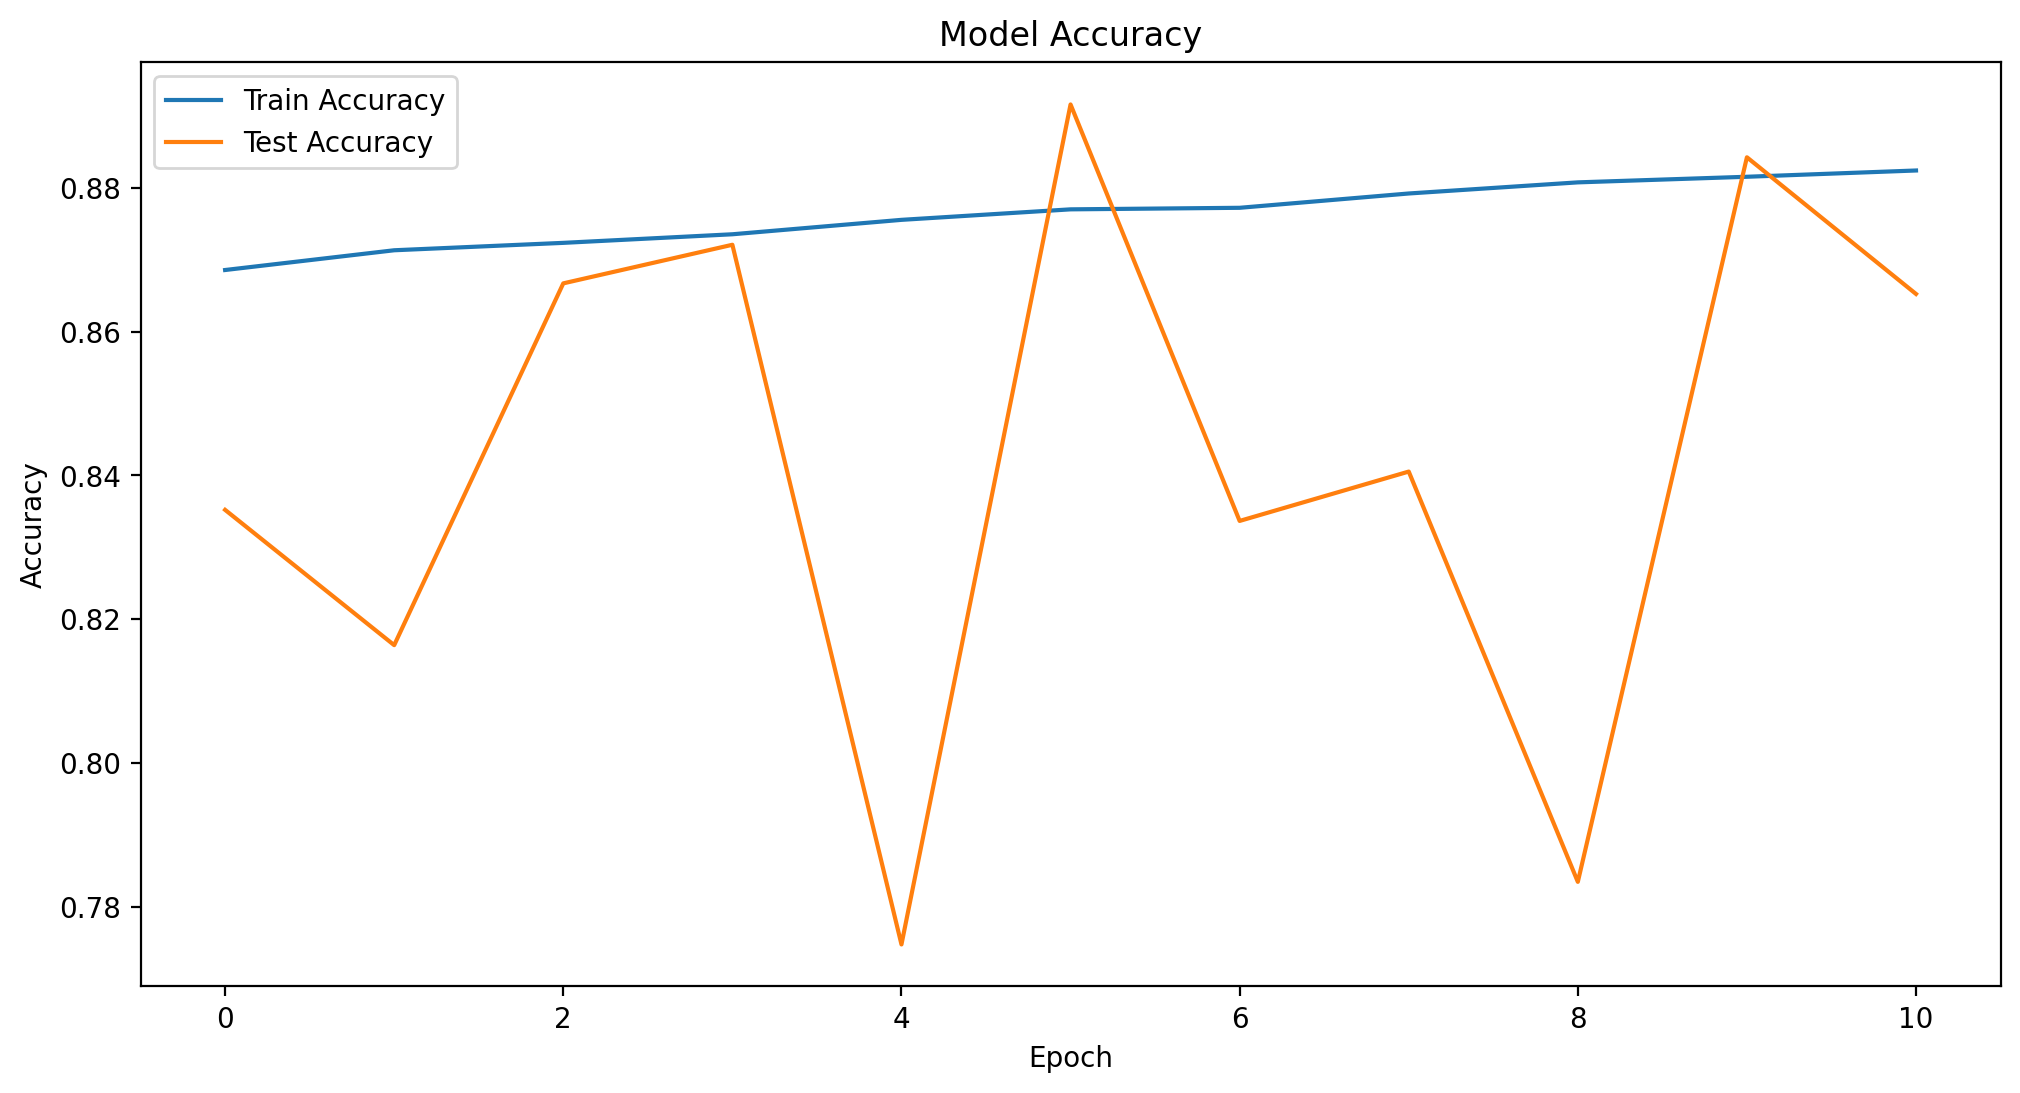

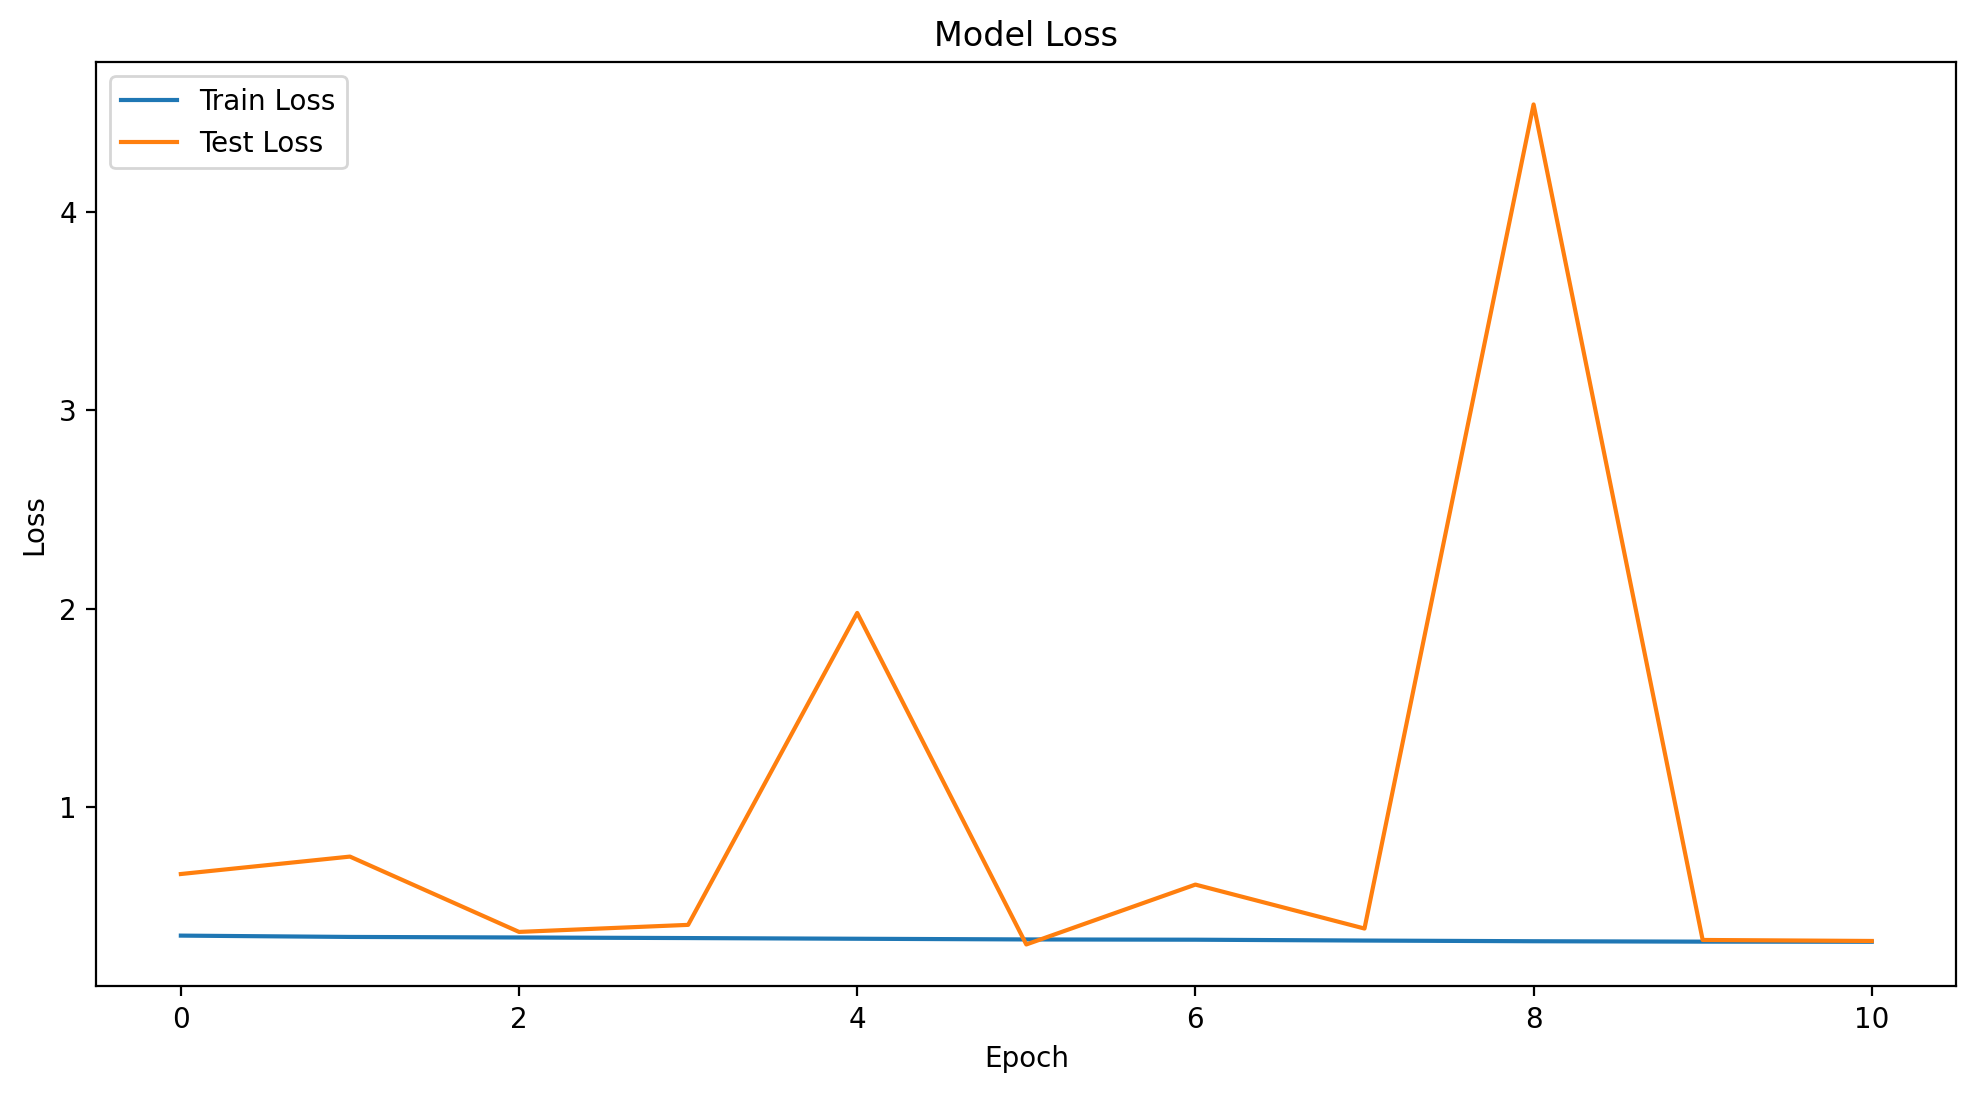

In [20]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_optimized.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_optimized.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_optimized.history['loss'], label='Train Loss')
plt.plot(history_cnn_optimized.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

###Plot confusion matrix

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


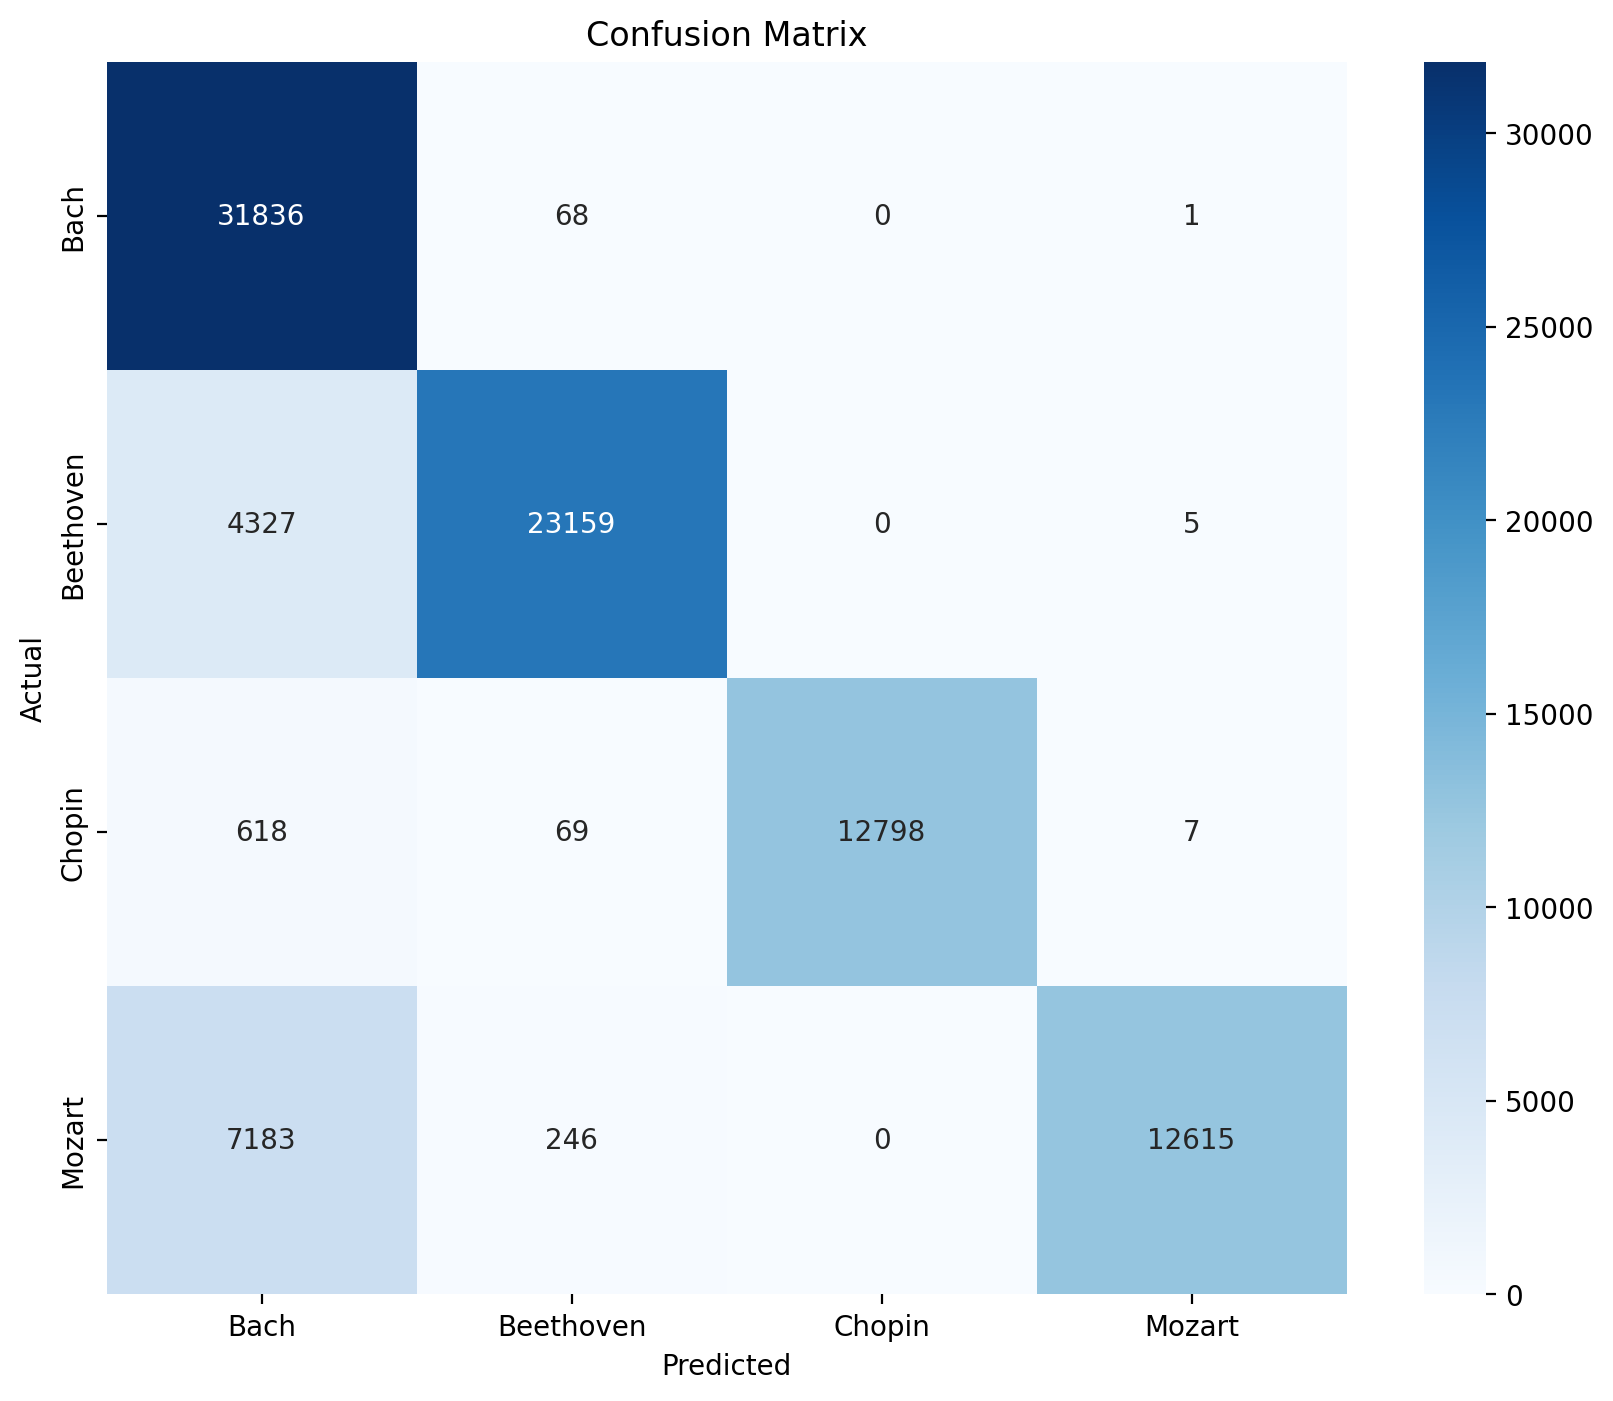

In [21]:
# plot confusion matrix for best_model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
